## Deep Dive into Deep Learning : Tensorflow 2.0 

In [45]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import math
import tensorflow as tf
import ktrain           # https://github.com/amaiya/ktrain

from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from sklearn.model_selection import train_test_split

from IPython.display import Image
from IPython.core.display import HTML 
print("using tensorflow {}".format(tf.__version__))
print("using ktrain {}".format(ktrain.__version__))

using tensorflow 2.1.0
using ktrain 0.9.4


### main differences to TF 1:
* "eager execution": more like Python instead of a compiled black box; no need for tf.session
* integrated keras as high level wrapper
* api cleanup: tf.slim, tf.layers, tf.contrib.layers and tf.keras combined into one
* data streaming via tf.data
* downwoards compatible to TF 1 code, or translate with v2 update script

## simple example: fit dense neural network to random dummy data

In [46]:
def denseLayer(input_layer, n, drop_rate, actFunc='relu'):
    "add a dense layer with n neurons and dropout rate drop_rate. Uses relu activation by default."
    dense = keras.layers.Dense(n, activation=actFunc)(input_layer)
    out = keras.layers.Dropout(drop_rate)(dense)
    return out


def makeNeuralNetwork(n_hidden_layers, n_neurons_hidden, n_neurons_output,
                      n_neurons_input, drop_rate, lossfunc, metrics_list, output_activation):
    # first layer
    inputs = keras.Input(shape=(n_neurons_input,), name='input')
    x = denseLayer(inputs, n_neurons_hidden, drop_rate)
    
    # middle layers
    for i in range(n_hidden_layers-1):
        x = denseLayer(x, n_neurons_hidden, drop_rate)
    # output layer
    outputs = denseLayer(x, n_neurons_output, 0, actFunc=output_activation) # often'softmax'
    
    # build and compile model
    model = keras.Model(inputs=inputs, outputs=outputs, name='my_classifier')
    model.compile(optimizer='adam',
              loss=lossfunc, # often 'sparse_categorical_crossentropy'
              metrics=metrics_list)  # often ['accuracy']
    return model

In [47]:
# dummy data
X = np.random.normal(size=(1000, 20))
y = np.random.randint(2, size=(1000, 4))
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1000, 20) (1000, 4)
(800, 20) (200, 20) (800, 4) (200, 4)


In [48]:
model_1 = makeNeuralNetwork(1, 50, y_train.shape[1], X_train.shape[1], 0.3, keras.losses.mean_squared_error,[], None)
# my mistake last time: the chosen loss function was only suitable for classification

In [49]:
# train model
hist_1 = model_1.fit(X_train, y_train,
                     batch_size=256,
                     epochs=50,
                     validation_data=(X_test, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 0s 433us/sample - loss: 1.1428 - val_loss: 0.8251
Epoch 2/50
800/800 [==============================] - 0s 11us/sample - loss: 1.0098 - val_loss: 0.7348
Epoch 3/50
800/800 [==============================] - 0s 12us/sample - loss: 0.9280 - val_loss: 0.6598
Epoch 4/50
800/800 [==============================] - 0s 12us/sample - loss: 0.8462 - val_loss: 0.5972
Epoch 5/50
800/800 [==============================] - 0s 11us/sample - loss: 0.7934 - val_loss: 0.5460
Epoch 6/50
800/800 [==============================] - 0s 12us/sample - loss: 0.7239 - val_loss: 0.5044
Epoch 7/50
800/800 [==============================] - 0s 12us/sample - loss: 0.7075 - val_loss: 0.4713
Epoch 8/50
800/800 [==============================] - 0s 11us/sample - loss: 0.6706 - val_loss: 0.4447
Epoch 9/50
800/800 [==============================] - 0s 11us/sample - loss: 0.6332 - val_loss: 0.4235
Epoch 10/50
800/800 [=====

In [50]:
# check predictions
y_pred = model_1.predict(X_test)
print(y_pred[:6])


[[ 0.3658665   0.44342804  0.34828284  0.80480516]
 [ 0.36161813  0.63061583  0.926602    0.2872154 ]
 [ 0.59241694  0.40189683  0.42476708  0.5442423 ]
 [-0.04870182  0.5857934   0.45868614  0.13244477]
 [ 0.29342487  0.5383121   0.39108562  0.429837  ]
 [ 0.47132918  0.5238828   0.4280735   0.4263641 ]]


dict_keys(['loss', 'val_loss'])


Text(0.5, 0, 'iteration')

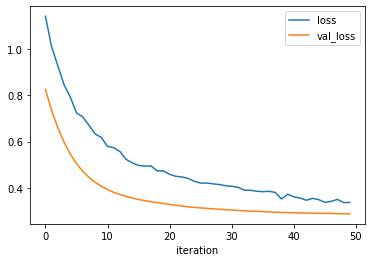

In [51]:
# plot loss
print(hist_1.history.keys())
plt.plot(hist_1.history['loss'], label="loss")
plt.plot(hist_1.history['val_loss'], label="val_loss")
plt.legend()
plt.xlabel("iteration")

## more meaningful example: classify images of cats and dogs

In [8]:
Image(url= "https://miro.medium.com/max/3288/1*uAeANQIOQPqWZnnuH-VEyw.jpeg")

In [81]:
# get data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [82]:
batch_size = 128   # we will train our model in batches. Large batches need lots of memory, but are faster (parallel)
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [83]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [84]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
print("{} cats in training set".format(num_cats_tr))
print("{} dogs in training set".format(num_dogs_tr))
print("{} cats in validation set".format(num_cats_val))
print("{} dogs in validation set".format(num_dogs_val))

1000 cats in training set
1000 dogs in training set
500 cats in validation set
500 dogs in validation set


In [100]:
# use "generators" that pre-process and feed images into the algorithm

train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [101]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [102]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [103]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

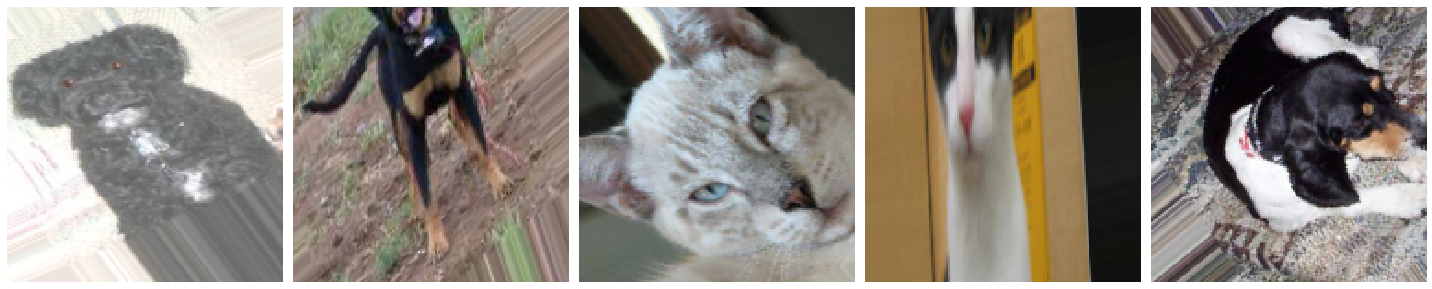

In [104]:
sample_training_images, _ = next(train_data_gen)

plotImages(sample_training_images[:5])

In [105]:
dropout_rate = 0.2

model_2 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(dropout_rate),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(dropout_rate),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)   # single value enough since only 2 classes
])

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [106]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 64)       

In [69]:
history_2 = model_2.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Train for 15 steps, validate for 7 steps
Epoch 1/15
15/15 [==============================] - 24s 2s/step - loss: 1.2372 - accuracy: 0.4957 - val_loss: 0.6922 - val_accuracy: 0.4944
Epoch 2/15
15/15 [==============================] - 23s 2s/step - loss: 0.6927 - accuracy: 0.4989 - val_loss: 0.6924 - val_accuracy: 0.4944
Epoch 3/15
15/15 [==============================] - 25s 2s/step - loss: 0.6920 - accuracy: 0.5026 - val_loss: 0.6919 - val_accuracy: 0.4944
Epoch 4/15
15/15 [==============================] - 24s 2s/step - loss: 0.6879 - accuracy: 0.5048 - val_loss: 0.6897 - val_accuracy: 0.4944
Epoch 5/15
15/15 [==============================] - 24s 2s/step - loss: 0.6830 - accuracy: 0.4973 - val_loss: 0.6834 - val_accuracy: 0.4944
Epoch 6/15
15/15 [==============================] - 25s 2s/step - loss: 0.6776 - accuracy: 0.5198 - val_loss: 0.6827 - val_accuracy: 0.4944
Epoch 7/15
15/15 [==============================] - 23s 2s/step - loss: 0.6730 - accuracy: 0.5134 - val_loss: 0.6664 - 

In [70]:
def plotHistory(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel("epoch")

    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel("epoch")
    plt.title('Training and Validation Loss')
    plt.show()

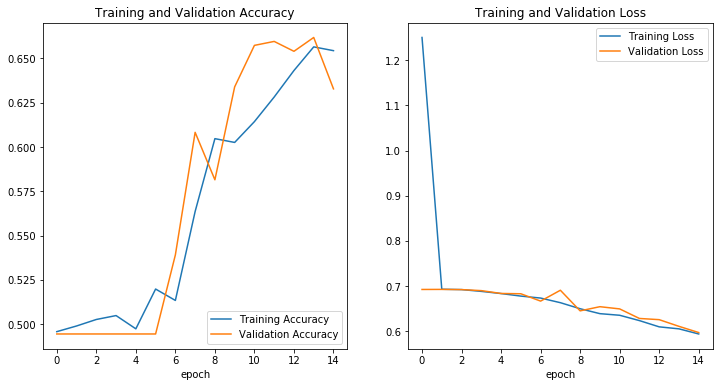

In [71]:
plotHistory(history_2, epochs)

## Transfer Learning
Why do all the work when someone else (Google) already trained a network on a similar dataset?

In [107]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
print(IMG_SHAPE)

(150, 150, 3)


In [108]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False  # freeze the weights! Important!

/Applications/anaconda3/envs/transferLearning/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [109]:
base_model.summary()  # fortunately, the loaded model works with the same image size! If not, cropping?

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

The shape of the current last layer is (None, 5, 5, 1280). Let's add layers to get to a binary classification

In [110]:
model_3 =  tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(), # This just takes the average over the (5,5) dimensions
  keras.layers.Dense(1)  # single neuron that will describe the classification result
])

In [111]:
model_3.summary()  # note: only the last layer is trainable!

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [77]:
base_learning_rate = 0.0001
model_3.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [78]:
history_3 = model_3.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Train for 15 steps, validate for 7 steps
Epoch 1/15
15/15 [==============================] - 39s 3s/step - loss: 0.7934 - accuracy: 0.4738 - val_loss: 0.8632 - val_accuracy: 0.4688
Epoch 2/15
15/15 [==============================] - 35s 2s/step - loss: 0.7307 - accuracy: 0.5491 - val_loss: 0.7634 - val_accuracy: 0.5435
Epoch 3/15
15/15 [==============================] - 35s 2s/step - loss: 0.7110 - accuracy: 0.5662 - val_loss: 0.6756 - val_accuracy: 0.6138
Epoch 4/15
15/15 [==============================] - 35s 2s/step - loss: 0.6623 - accuracy: 0.5956 - val_loss: 0.6038 - val_accuracy: 0.6562
Epoch 5/15
15/15 [==============================] - 35s 2s/step - loss: 0.6481 - accuracy: 0.6229 - val_loss: 0.5444 - val_accuracy: 0.6987
Epoch 6/15
15/15 [==============================] - 35s 2s/step - loss: 0.6155 - accuracy: 0.6496 - val_loss: 0.4882 - val_accuracy: 0.7455
Epoch 7/15
15/15 [==============================] - 35s 2s/step - loss: 0.5984 - accuracy: 0.6613 - val_loss: 0.4448 - 

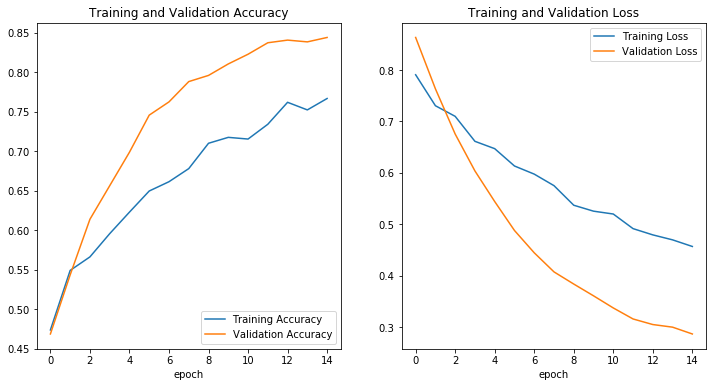

In [79]:
plotHistory(history_3, epochs)  # much better performance with same epochs

## NLP - working with text
typical tasks can be:
* translation
* predict next or missing word in sentence, or whole text generation
* sentiment analysis: positive/negative review, happy/angry/sad/, understand topic (tagging!)
* answer a question, given a text containing the answer
* Chatbots

big improvements recently:
- "old style" (2010s): LSTM = Long Short Term Memory, basically a RNN with memory state
- "new kid on the block" (2018): BERT = Bidirectional Encoder Representations from Transformers
    * paper: https://arxiv.org/pdf/1810.04805.pdf
    * pretrained in unsupervised way by taking a corpus and predict masked words and whether one sentence follows another or is unrelated
    * can add layer at the end and fine-tune on specific task, just like ImageNet for images
    * architecture contains the encoder part of transformers and attention mechanisms https://arxiv.org/abs/1706.03762

In [31]:
Image(url= "https://miro.medium.com/max/2300/1*pE0lYanFGi80ILtK1HF11g.jpeg")  # google before and after BERT

In [3]:
# load dataset; downloaded from https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
data = pd.read_csv("~/Documents/tmp/bbc-text.csv")
data = data.dropna(axis=0) # drop rows with Nulls
data = data.sample(frac=1).reset_index(drop=True) # shuffle

print("Total datapoints: {}".format(len(data)))
print(data["category"].value_counts())
data.head()

Total datapoints: 2225
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
# split
classes = list(data['category'].unique())
print(classes)

train_size = int(len(data) * .8)
myDict = {key : i for i,key in enumerate(classes)}
print(myDict)

data["category"] = data["category"].map(myDict)

x_train = data['text'][:train_size].to_list()
x_test = data['text'][train_size:].to_list()
y_train = data['category'][:train_size].to_list()
y_test = data['category'][train_size:].to_list()

print ("Train size: %d" % len(x_train))
print ("Test size: %d" % len(x_test))

['tech', 'business', 'sport', 'entertainment', 'politics']
{'tech': 0, 'business': 1, 'sport': 2, 'entertainment': 3, 'politics': 4}
Train size: 1780
Test size: 445


### https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb

In [5]:
from ktrain import text

MODEL_NAME = 'distilbert-base-uncased'  # choose a model!
t = text.Transformer(MODEL_NAME, maxlen=500, classes=classes)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(
    model,
    train_data=trn,
    #val_data=val,
    batch_size=6
)

preprocessing train...
language: en
train sequence lengths:
	mean : 394
	95percentile : 734
	99percentile : 1047


preprocessing test...
language: en
test sequence lengths:
	mean : 375
	95percentile : 741
	99percentile : 909


In [6]:
model.summary()  # too many parameters to learn!

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  3845      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,957,317
Trainable params: 66,957,317
Non-trainable params: 0
_________________________________________________________________


In [7]:
# freeze first layer!

model.get_layer('distilbert').trainable = False

model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  3845      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,957,317
Trainable params: 594,437
Non-trainable params: 66,362,880
_________________________________________________________________


### inspect training data:
* each text has 500 tokens
* as i understand, the additional 2 rows under the tokens describe if there is a token at all and whether it belongs to sentence 0 or sentence 1 (which we don't have, but would exist in some problems)
* the second matrix in the tuple is a mask used to cover words, for each batch a different one. This is how unsupervised training was done, predict the missing word, but we don't need it here.


In [10]:
print("total training examples: {}".format(len(x_train)))  
print(trn[0][0].shape, trn[0][1].shape)  
print(len(trn))   # number of training examples per batch
trn[0]

total training examples: 1780
(6, 3, 500) (6, 5)
297


(array([[[  101,  2694,  2925, ...,  6833,  2071,   102],
         [    1,     1,     1, ...,     1,     1,     1],
         [    0,     0,     0, ...,     0,     0,     0]],
 
        [[  101,  2088,  9006, ...,     0,     0,     0],
         [    1,     1,     1, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0]],
 
        [[  101,  7600, 15705, ...,     0,     0,     0],
         [    1,     1,     1, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0]],
 
        [[  101,  6300, 23782, ...,     0,     0,     0],
         [    1,     1,     1, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0]],
 
        [[  101,  4153,  1055, ...,     0,     0,     0],
         [    1,     1,     1, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0]],
 
        [[  101,  4922,  4978, ...,  2651,  5146,   102],
         [    1,     1,     1, ...,     1,     1,     1],

In [12]:
# let's train the model!
learner = ktrain.get_learner(
    model,
    train_data=trn,
    #val_data=val,  # leave out, to make 100% sure no test data gets into training
    batch_size=6
)
learner.fit_onecycle(
    8e-5,  # learning rate (which is cyclically changing over time)
    1,     # epochs
)



begin training using onecycle policy with max lr of 8e-05...
Train for 297 steps
297/297 [==============================] - 666s 2s/step - loss: 1.1870 - accuracy: 0.7017


In [13]:
predictions = learner.predict(val)

In [14]:
predictions_max = np.argmax(predictions, axis=1).reshape((len(predictions),1))
predictions_max.shape

(445, 1)

In [21]:
truth = np.asarray(y_test).reshape((len(y_test),1))
print(truth.shape, predictions.shape)
preds_and_truth = pd.DataFrame(np.concatenate((predictions, truth, predictions_max),  axis=1),
                               columns=[*[str(x) for x in range(len(classes))], "truth", "prediction"])
print(preds_and_truth.shape)

preds_and_truth["highest_prob"] = preds_and_truth.drop(["truth", "prediction"], axis=1).max(axis=1)
preds_and_truth["correct"] = preds_and_truth["truth"] == preds_and_truth["prediction"]

(445, 1) (445, 5)
(445, 7)


In [22]:
preds_and_truth.head(10)

,0,1,2,3,4,truth,prediction,highest_prob,correct
0,0.158606,0.154451,0.139669,0.436098,0.111176,3.0,3.0,0.436098,True
1,0.350358,0.153366,0.113421,0.268681,0.114174,0.0,0.0,0.350358,True
2,0.056280,0.071994,0.050293,0.052242,0.769191,4.0,4.0,0.769191,True
3,0.157661,0.102703,0.376742,0.257792,0.105101,2.0,2.0,0.376742,True
4,0.068345,0.085244,0.656636,0.139318,0.050456,2.0,2.0,0.656636,True
5,0.268520,0.116469,0.112077,0.400828,0.102106,0.0,3.0,0.400828,False
6,0.136078,0.416583,0.096066,0.131309,0.219964,1.0,1.0,0.416583,True
7,0.290601,0.237087,0.147606,0.209965,0.114741,0.0,0.0,0.290601,True
8,0.190196,0.141753,0.108246,0.299902,0.259903,3.0,3.0,0.299902,True
9,0.191681,0.176475,0.111874,0.413963,0.106007,3.0,3.0,0.413963,True


In [36]:
# very nice results!
print("confusion matrix:")
print(sklearn.metrics.confusion_matrix(
    preds_and_truth["truth"],
    preds_and_truth["prediction"]))
print("stats:")
print(sklearn.metrics.classification_report(
    preds_and_truth["truth"],
    preds_and_truth["prediction"],
    labels=list(myDict.values()),
))
print(myDict)

confusion matrix:
[[ 75   5   1   5   0]
 [  1 101   0   0   4]
 [  0   2  99   0   0]
 [  0   0   1  64   1]
 [  0   3   0   1  82]]
stats:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93        86
           1       0.91      0.95      0.93       106
           2       0.98      0.98      0.98       101
           3       0.91      0.97      0.94        66
           4       0.94      0.95      0.95        86

    accuracy                           0.95       445
   macro avg       0.95      0.95      0.95       445
weighted avg       0.95      0.95      0.95       445

{'tech': 0, 'business': 1, 'sport': 2, 'entertainment': 3, 'politics': 4}


In [40]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [113]:
s_1 = 'the stock market crashed and consumer expectations faltered, even though the weather was nice.'
s_2 = 'Beyonce gave a great concert yesterday.'
s_3 = 'the Lakers scored again in the last half of the game'
s_4 = 'sometimes i run out of RAM on my machine'
s_5 = 'Brexit negotiations will be a marathon, not a sprint'  # trying to confuse it with sports vocabulary
s_6 = 'in his speech, prime minister Abe came to the conclusion'
s_7 = 'Putin and Merkel met for a drink and the date was horrible'

for s in [s_1, s_2, s_3, s_4, s_5, s_6, s_7]:
    print(predictor.predict(s))

business


entertainment


sport


tech


business


politics


entertainment


### explainability
the ktrain model also allows explaining its predictions (both text and images): 
    https://medium.com/@asmaiya/explainable-ai-in-practice-2e5ae2d16dc7

In [42]:
#predictor.explain(s_7) # will highlight important words. doesn't currently work...

### further topics:
* tensorboard (and other callbacks)
* distributed training (GPU!)
* more complicated network architectures (GAN, encoder-decoder, style transfer...)